In [ ]:
# Create a directory to store the data in the current working directory
mkdir -p data

# Download the data
curl https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz

# Navigate to the data directory
cd data

# Unpack the data
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

# Navigate back to the parent directory
cd ..

# Create a directory for writing processed data
mkdir -p write


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

In [17]:
# Path to the matrix
matrix_dir = '/Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/data/filtered_gene_bc_matrices/hg19/'

# Load the data into an AnnData object
adata = sc.read_10x_mtx(
    matrix_dir,
    var_names='gene_symbols',
    cache=True
)

# Optionally save the AnnData object
adata.write('/Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/write/pbmc3k.h5ad')


In [22]:
adata = sc.read_h5ad('/Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/write/pbmc3k.h5ad')

In [19]:
#####Create PseudoBulk data
###For testing purposes

# Number of samples
n_samples = 25

# Create an array to store sample labels for each cell
sample_labels = np.repeat(np.arange(n_samples), len(adata.obs) // n_samples + 1)[:len(adata.obs)]

# Add sample labels to the observations
adata.obs['sample'] = sample_labels

# Sum the counts for each sample
bulk_counts = adata.to_df().groupby(adata.obs['sample']).sum()

# Create a new DataFrame for pseudobulk data
pseudobulk_data = pd.DataFrame(bulk_counts, columns=adata.var_names)

# Save the pseudobulk data
pseudobulk_data.to_csv('/Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/write/pseudobulk_data.csv')

In [25]:
pseudobulk_data.head

<bound method NDFrame.head of         MIR1302-10  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  AL627309.1  \
sample                                                                       
0              0.0      0.0    0.0           0.0           0.0         0.0   
1              0.0      0.0    0.0           0.0           0.0         0.0   
2              0.0      0.0    0.0           0.0           0.0         0.0   
3              0.0      0.0    0.0           0.0           0.0         0.0   
4              0.0      0.0    0.0           0.0           0.0         1.0   
5              0.0      0.0    0.0           0.0           0.0         0.0   
6              0.0      0.0    0.0           0.0           0.0         0.0   
7              0.0      0.0    0.0           0.0           0.0         0.0   
8              0.0      0.0    0.0           0.0           0.0         0.0   
9              0.0      0.0    0.0           0.0           0.0         1.0   
10             0.0      0.0    0.0

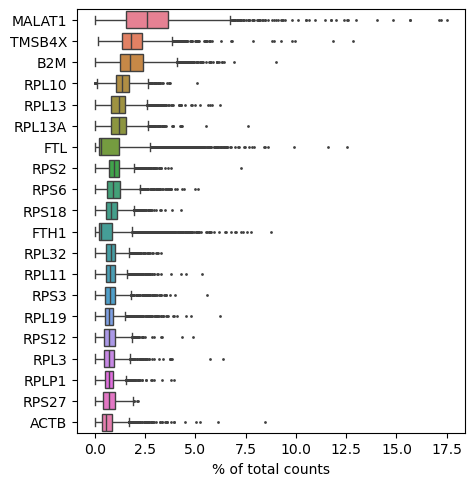

/opt/miniconda3/envs/Statescope_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


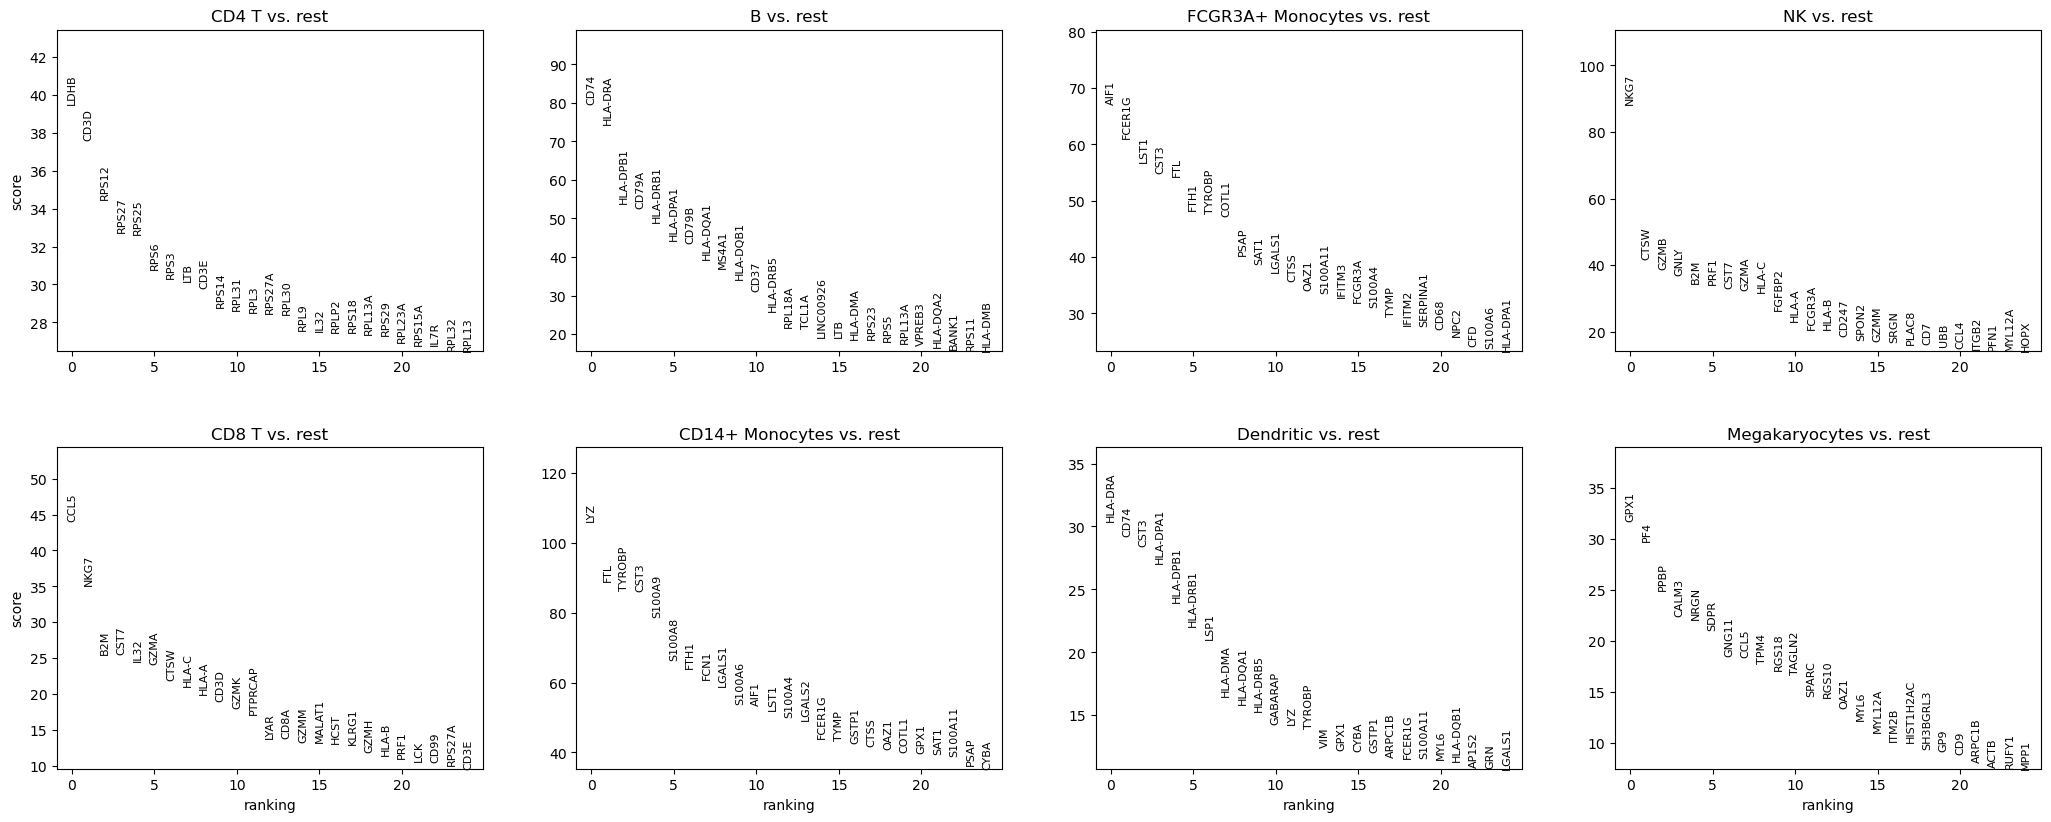

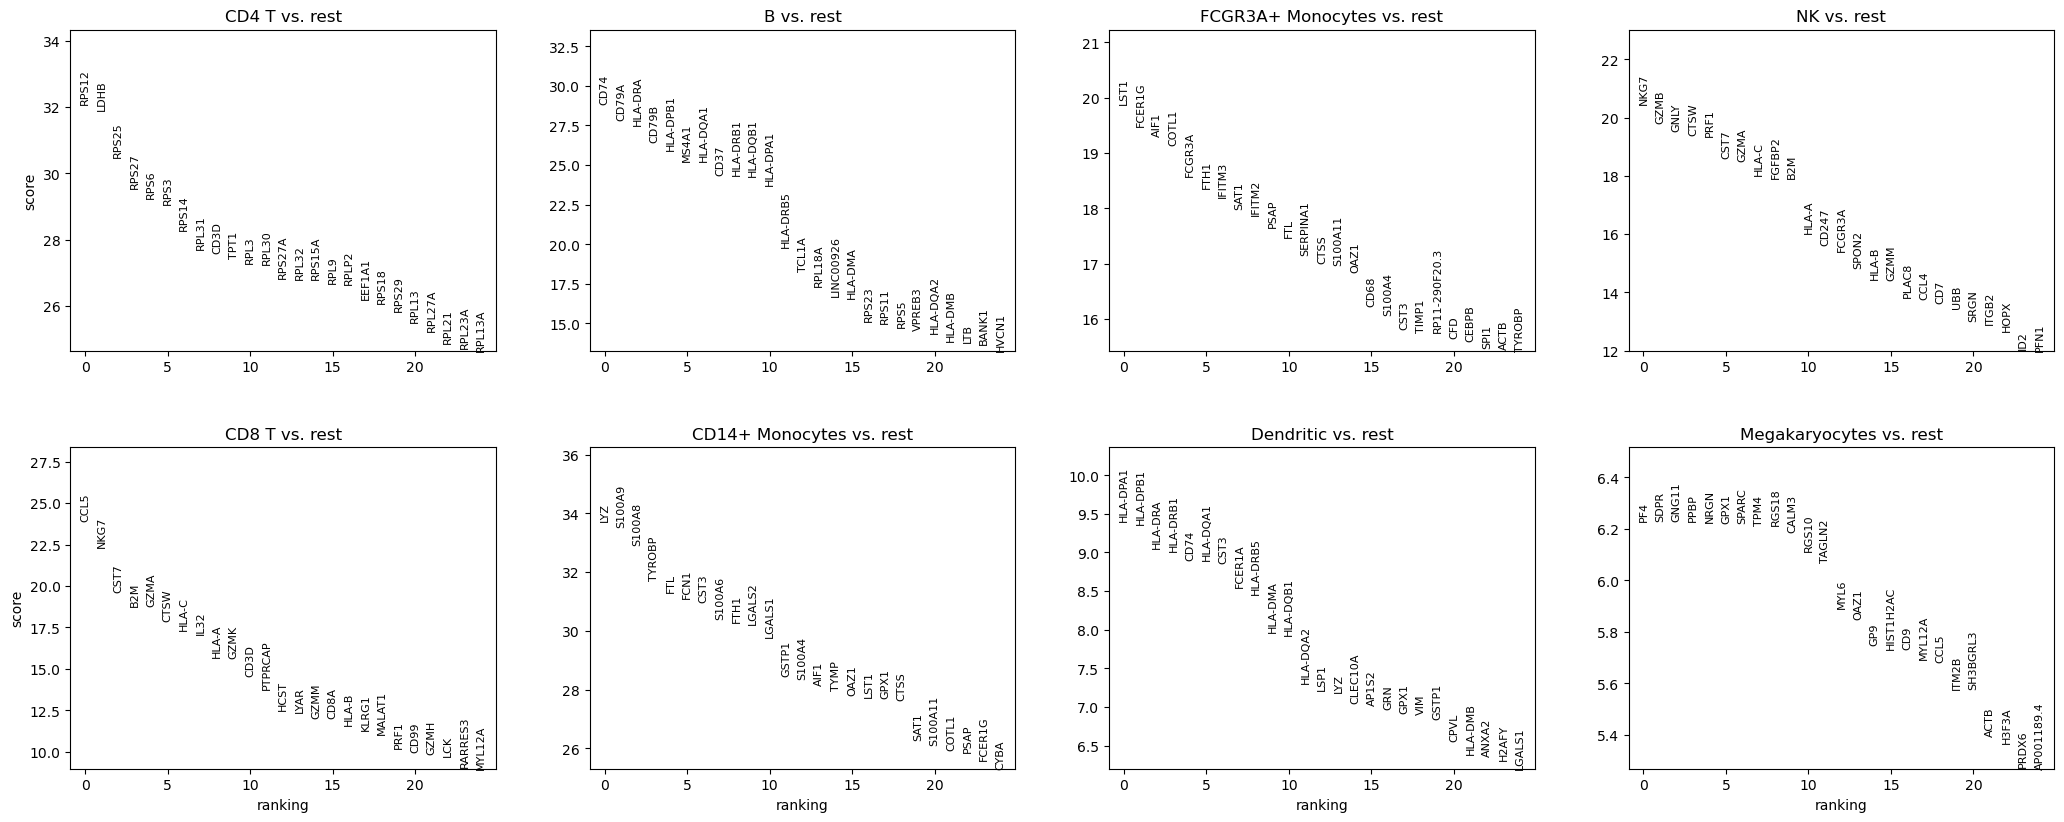

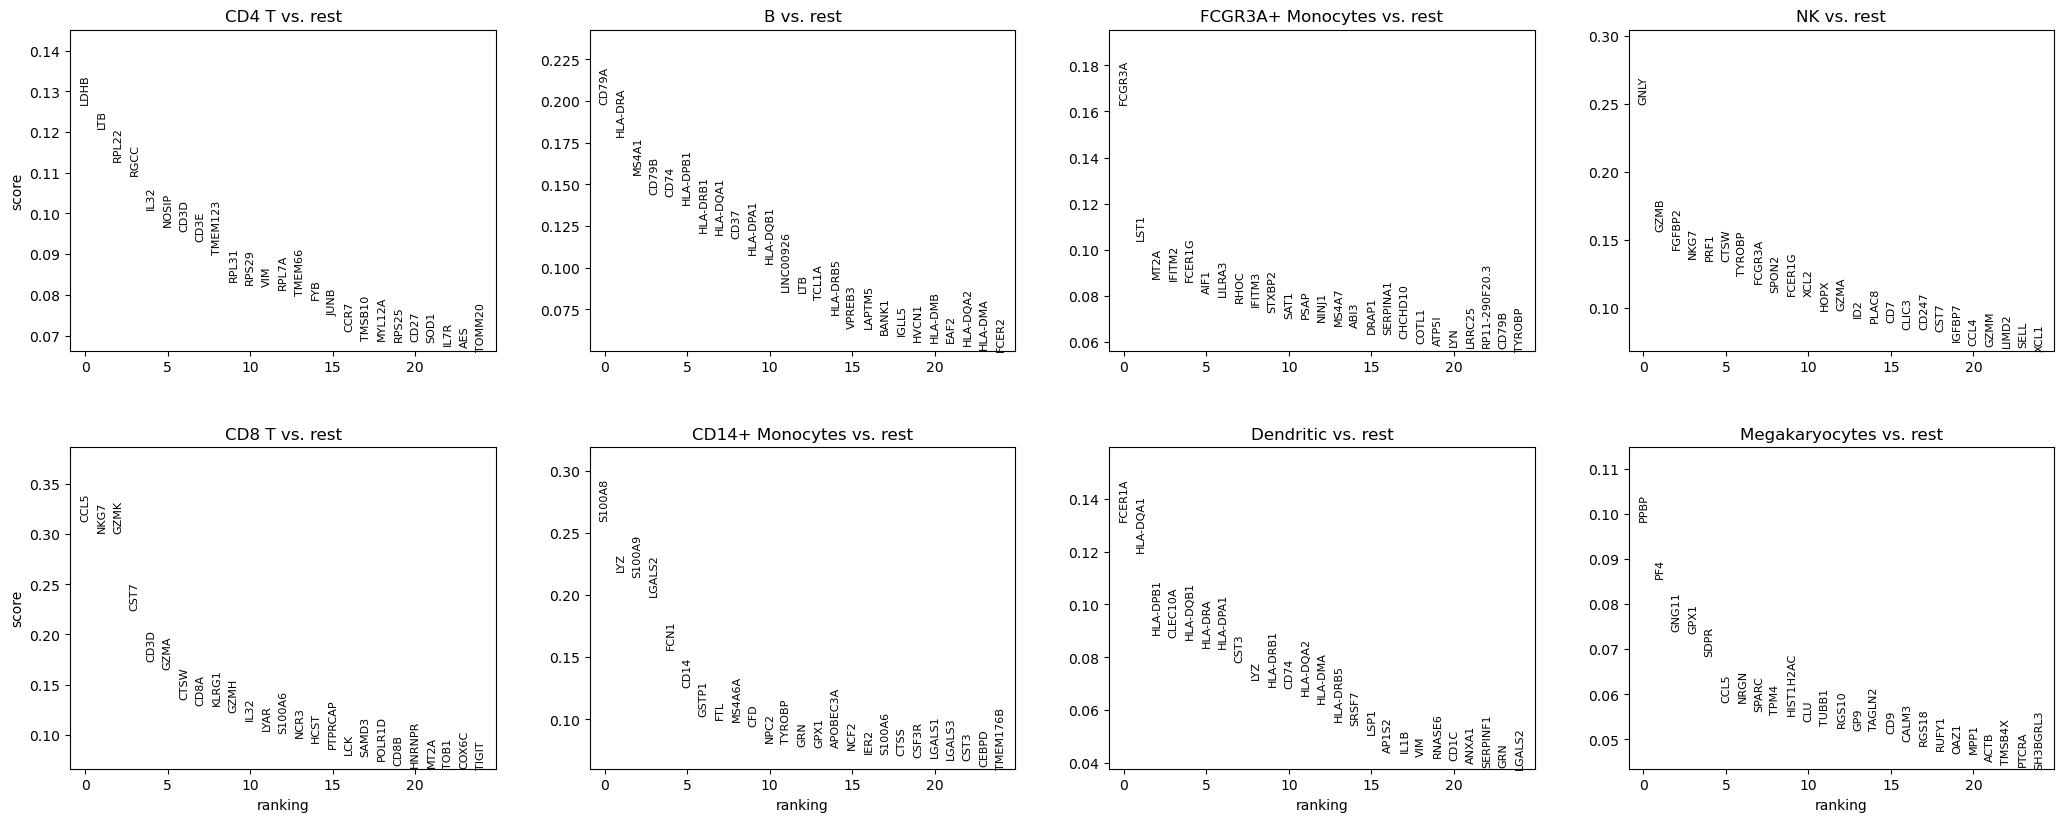

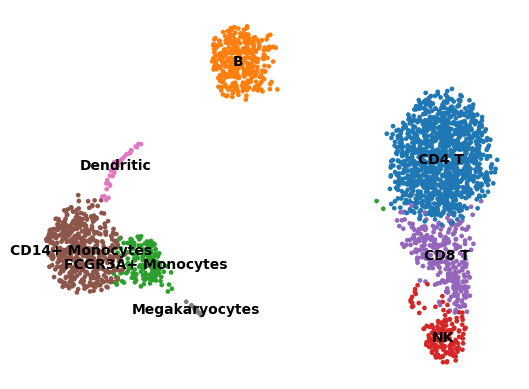

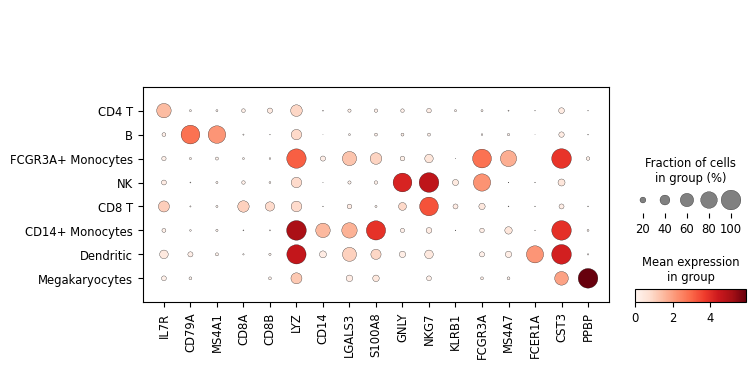

In [23]:
# Preprocess the data
adata.var_names_make_unique()
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

# Save raw data in adata_raw
adata_raw = adata.copy()

# Normalization and feature selection
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata.copy()  # Store the normalized and log-transformed data
adata = adata[:, adata.var.highly_variable]

# Regression and scaling
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

# PCA and neighborhood graph
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Clustering
sc.tl.leiden(adata, resolution=0.9, random_state=0, flavor="igraph", n_iterations=2, directed=False)

# Update cluster names
new_cluster_names = [
    "CD4 T", "B", "FCGR3A+ Monocytes", "NK", "CD8 T",
    "CD14+ Monocytes", "Dendritic", "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

# PAGA to initialize UMAP
sc.tl.paga(adata, groups='leiden')  # ensure 'leiden' is the key for clusters
sc.pl.paga(adata, plot=False)  # Optionally visualize the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

# Further analysis
sc.tl.umap(adata)
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Define and visualize marker genes
marker_genes = [
    "IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14",
    "LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1",
    "FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP",
]
sc.pl.umap(adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf")
sc.pl.dotplot(adata, marker_genes, groupby="leiden")


In [26]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD4 T
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,FCGR3A+ Monocytes
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422,B
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150,B
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795,B


In [29]:
####Save the data in appropriate format 
adata.obs = adata.obs
adata = adata_raw[:, adata.var_names]
adata.var = adata.var
adata.uns = adata.uns
save_path = '/Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/write/PBMC_scRNA.h5ad'
adata_raw.write(save_path)

print(f"Data saved successfully to {save_path}")



Data saved successfully to /Users/aryamaanbose/Desktop/Statescope-dev/Statescope/test/write/PBMC_scRNA.h5ad


/opt/miniconda3/envs/Statescope_env/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  getattr(self, attr).index = value
